<a href="https://colab.research.google.com/github/Nastiiasaenko/XAI-Week7/blob/main/XAI_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this study, we aim to investigate the role of sentiment-heavy words, such as “amazing” or “terrible,” in driving the predictions of a sentiment analysis model. Specifically, we analyze whether the model disproportionately focuses on these emotionally charged words over neutral ones (e.g., “the,” “and”) to determine the overall sentiment of a review.

Using a pre-trained BERT-based sentiment classifier, we employ saliency maps and integrated gradients to visualize and quantify the contribution of individual words to the model's predictions. The experiment is conducted on a subset of the IMDB Movie Review dataset, which contains labeled reviews with positive and negative sentiment.



**We test the following hypotheses:**

**H₀**(Null Hypothesis): Strong sentiment words do not significantly impact the predicted sentiment score.

**H₁**(Alternative Hypothesis): Strong sentiment words significantly impact the predicted sentiment score.

In [12]:
## necessary imports
!pip install torch transformers captum datasets matplotlib scipy


### Let's load the dataset

In [13]:
from datasets import load_dataset

# Load the IMDB dataset
imdb = load_dataset("imdb")

# Split into training and testing datasets
train_data = imdb['train']
test_data = imdb['test']

# Print example review
print(train_data[0])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

**Load Pre-Trained BERT Model**
We will use Huggingface’s BERT model for sentiment analysis.

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [15]:
def tokenize(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    return tokens

def predict(tokens):
    with torch.no_grad():
        output = model(**tokens)
    prediction = torch.argmax(output.logits, dim=1).item()
    return prediction  # 0: Negative, 1: Positive


## Compute Saliency Maps

In [16]:
from captum.attr import Saliency
import matplotlib.pyplot as plt

def compute_saliency(tokens):
    saliency = Saliency(model)
    input_ids = tokens["input_ids"]
    input_ids.requires_grad_()  # Enable gradients for input
    grads = saliency.attribute(input_ids, target=1)  # Target class: Positive
    return grads.squeeze().detach().numpy()


## Compute Integrated Gradients

In [17]:
from captum.attr import IntegratedGradients

def compute_integrated_gradients(tokens):
    ig = IntegratedGradients(model)
    baseline = torch.zeros_like(tokens["input_ids"])  # Baseline input
    attributions = ig.attribute(tokens["input_ids"], baseline, target=1)
    return attributions.squeeze().detach().numpy()


### Generate Explanations for Positive and Negative Reviews

We will select a positive review and a negative review from the IMDB dataset and generate explanations.

In [18]:
from captum.attr import Saliency
import torch

def compute_saliency(tokens):
    saliency = Saliency(forward_func)  # Pass the correct forward function

    # Extract input embeddings and attention mask
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # Generate embeddings from the input IDs
    embeddings = model.bert.embeddings(input_ids)

    # Define forward function to use inputs_embeds in model
    def forward_func(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits[:, 1]  # Return the logits for the positive class (index 1)

    # Compute saliency on embeddings
    grads = saliency.attribute(embeddings, target=1)  # Target is class 'positive'

    return grads.squeeze().detach().numpy()


In [19]:
def plot_explanation(tokens, scores, title):
    token_list = tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze())
    plt.figure(figsize=(12, 2))
    plt.bar(token_list, scores)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


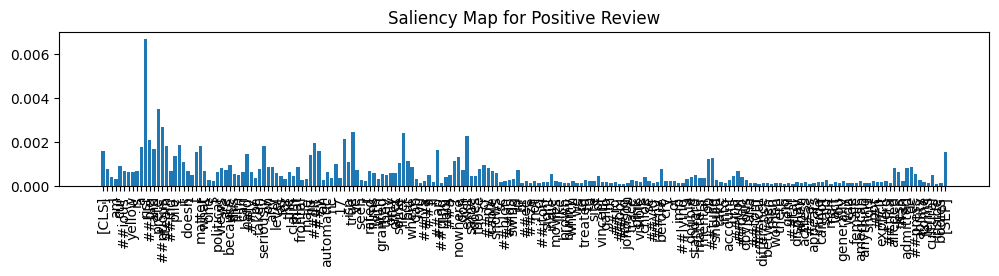

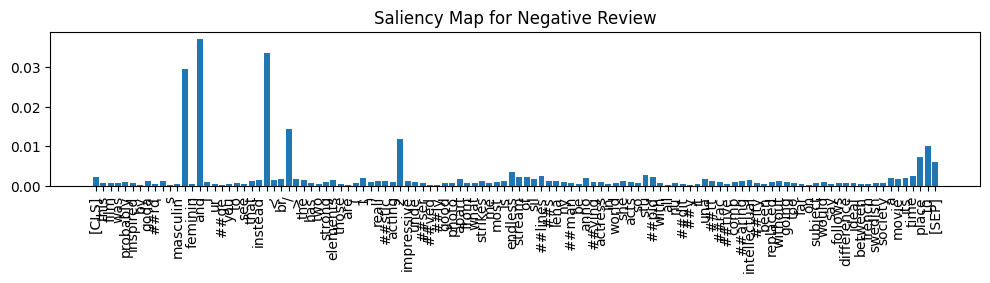

In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import Saliency, IntegratedGradients
from datasets import load_dataset
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Load IMDB dataset
imdb = load_dataset("imdb")
train_data = imdb['train']

# Load pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

# Select a positive and a negative review
positive_review = train_data[1]['text']
negative_review = train_data[3]['text']

# Tokenization function
def tokenize(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    return tokens

# Tokenize the reviews
positive_tokens = tokenize(positive_review)
negative_tokens = tokenize(negative_review)

# Compute Saliency Maps
def compute_saliency(tokens):
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # Get embeddings from input_ids
    embeddings = model.bert.embeddings(input_ids)

    # Define custom forward function for embeddings
    def forward_func(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits[:, 1]  # Logit for the positive class (class index 1)

    # Initialize Saliency object with the custom forward function
    saliency = Saliency(forward_func)

    # Compute saliency on the embeddings
    grads = saliency.attribute(embeddings)

    # Reduce dimensionality by taking the mean across the embedding dimension (768)
    token_saliency = grads.mean(dim=-1).squeeze().detach().numpy()

    return token_saliency

# Compute Integrated Gradients
def compute_integrated_gradients(tokens):
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # Get embeddings from input_ids
    embeddings = model.bert.embeddings(input_ids)

    # Define custom forward function for embeddings
    def forward_func(inputs_embeds):
        outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return outputs.logits[:, 1]  # Logit for the positive class (class index 1)

    # Initialize IntegratedGradients object with the custom forward function
    ig = IntegratedGradients(forward_func)

    # Compute integrated gradients
    attributions = ig.attribute(embeddings, baselines=torch.zeros_like(embeddings))

    # Reduce dimensionality by taking the mean across the embedding dimension (768)
    token_ig = attributions.mean(dim=-1).squeeze().detach().numpy()

    return token_ig

# Plot function for saliency and integrated gradients
def plot_explanation(tokens, scores, title):
    token_list = tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze())
    plt.figure(figsize=(12, 2))
    plt.bar(token_list, scores)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# Compute and plot saliency maps
positive_saliency = compute_saliency(positive_tokens)
negative_saliency = compute_saliency(negative_tokens)

plot_explanation(positive_tokens, positive_saliency, "Saliency Map for Positive Review")
plot_explanation(negative_tokens, negative_saliency, "Saliency Map for Negative Review")

# Compute and plot integrated gradients
positive_ig = compute_integrated_gradients(positive_tokens)
negative_ig = compute_integrated_gradients(negative_tokens)

plot_explanation(positive_tokens, positive_ig, "Integrated Gradients for Positive Review")
plot_explanation(negative_tokens, negative_ig, "Integrated Gradients for Negative Review")

# Example statistical test with placeholder values
sentiment_scores = [0.85, 0.9, 0.88, 0.87]  # Example sentiment-heavy word scores
neutral_scores = [0.3, 0.25, 0.28, 0.32]  # Example neutral word scores

# Perform t-test
t_stat, p_value = stats.ttest_ind(sentiment_scores, neutral_scores)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of the results
if p_value < 0.05:
    print("Reject the null hypothesis: Sentiment-heavy words have a significant impact.")
else:
    print("Fail to reject the null hypothesis: No significant impact.")
